In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
batch_size_train = 100
batch_size_test = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('cifar10', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR10('cifar10', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 13035598.66it/s]


Extracting cifar10/cifar-10-python.tar.gz to cifar10
Files already downloaded and verified


In [4]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc0 = nn.Linear(3072,1024)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = x.view((-1,3072))
        x = F.relu(self.fc0(x))
        return self.fc1(x)

In [5]:

model = mlp().cuda()
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'CIFAR10_Normal_MLP_leastLoss.pt')
        test_loss_min = test_loss
    if test_acc >= test_acc_max:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max, test_acc))
        torch.save(model.state_dict(), 'CIFAR10_Normal_MLP_Most_Accuracy.pt')
        test_acc_max = test_acc
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.812732 - Testing Loss: 1.662921 - Training Accuracy: 35.87% - Testing Accuracy: 41.67%
Testing loss decreased (inf --> 1.662921). The new model saved.
Testing Acc increased (-100.000000 --> 41.670000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.595342 - Testing Loss: 1.555474 - Training Accuracy: 43.50% - Testing Accuracy: 45.17%
Testing loss decreased (1.662921 --> 1.555474). The new model saved.
Testing Acc increased (41.670000 --> 45.170000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.506978 - Testing Loss: 1.523840 - Training Accuracy: 46.82% - Testing Accuracy: 45.98%
Testing loss decreased (1.555474 --> 1.523840). The new model saved.
Testing Acc increased (45.170000 --> 45.980000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.451890 - Testing Loss: 1.497712 - Training Accuracy: 48.86% - Testing Accuracy: 46.91%
Testing loss decreased (1.523840 --> 1.497712). The new model saved.
Testing Acc increased (45.980000 --> 46.910000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.403192 - Testing Loss: 1.511865 - Training Accuracy: 50.48% - Testing Accuracy: 46.76%
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.353377 - Testing Loss: 1.450923 - Training Accuracy: 52.27% - Testing Accuracy: 48.16%
Testing loss decreased (1.497712 --> 1.450923). The new model saved.
Testing Acc increased (46.910000 --> 48.160000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.313929 - Testing Loss: 1.441849 - Training Accuracy: 53.81% - Testing Accuracy: 49.60%
Testing loss decreased (1.450923 --> 1.441849). The new model saved.
Testing Acc increased (48.160000 --> 49.600000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.275773 - Testing Loss: 1.397360 - Training Accuracy: 55.20% - Testing Accuracy: 51.41%
Testing loss decreased (1.441849 --> 1.397360). The new model saved.
Testing Acc increased (49.600000 --> 51.410000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.243906 - Testing Loss: 1.447609 - Training Accuracy: 56.18% - Testing Accuracy: 49.60%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.205018 - Testing Loss: 1.427597 - Training Accuracy: 57.61% - Testing Accuracy: 50.95%
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.165559 - Testing Loss: 1.427627 - Training Accuracy: 58.96% - Testing Accuracy: 50.98%
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 1.135134 - Testing Loss: 1.434130 - Training Accuracy: 60.24% - Testing Accuracy: 51.82%
Testing Acc increased (51.410000 --> 51.820000). The new model saved.
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.105749 - Testing Loss: 1.435749 - Training Accuracy: 61.35% - Testing Accuracy: 51.13%
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.083239 - Testing Loss: 1.479898 - Training Accuracy: 61.93% - Testing Accuracy: 50.80%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.048318 - Testing Loss: 1.479543 - Training Accuracy: 63.33% - Testing Accuracy: 51.30%
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 1.010812 - Testing Loss: 1.452474 - Training Accuracy: 64.47% - Testing Accuracy: 52.22%
Testing Acc increased (51.820000 --> 52.220000). The new model saved.
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.991213 - Testing Loss: 1.503540 - Training Accuracy: 65.44% - Testing Accuracy: 51.65%
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.964786 - Testing Loss: 1.480527 - Training Accuracy: 66.11% - Testing Accuracy: 52.22%
Testing Acc increased (52.220000 --> 52.220000). The new model saved.
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.937981 - Testing Loss: 1.573779 - Training Accuracy: 67.16% - Testing Accuracy: 51.09%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.912412 - Testing Loss: 1.541735 - Training Accuracy: 68.15% - Testing Accuracy: 51.18%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.886947 - Testing Loss: 1.549869 - Training Accuracy: 68.98% - Testing Accuracy: 52.51%
Testing Acc increased (52.220000 --> 52.510000). The new model saved.
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.860762 - Testing Loss: 1.604656 - Training Accuracy: 69.95% - Testing Accuracy: 51.40%
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.842149 - Testing Loss: 1.573305 - Training Accuracy: 70.50% - Testing Accuracy: 52.30%
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.824577 - Testing Loss: 1.635599 - Training Accuracy: 71.15% - Testing Accuracy: 51.64%


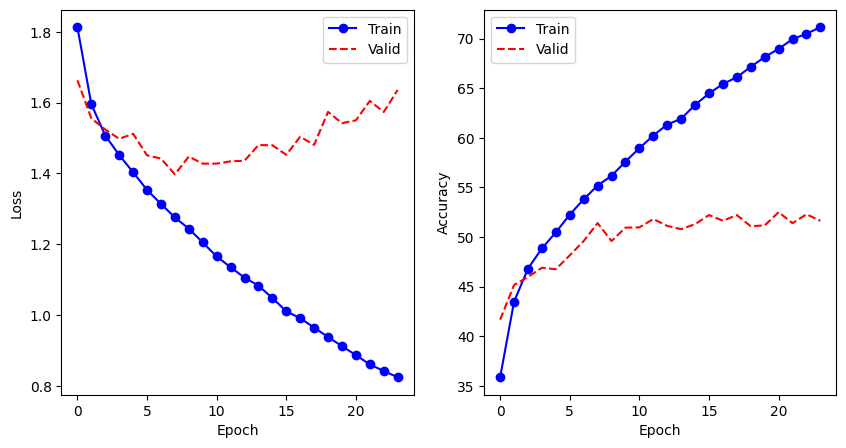

In [6]:
import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [7]:
modelSynScaL = mlp().cuda()
test_loss_min_SynScaL = np.Inf
LR=5e-4
optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)
test_acc_max_SynScaL = -100
historySynScaL = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)

    modelSynScaL.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target)+ 1.0 * (0.1 - output.mean())**2
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    modelSynScaL.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target) +  1.0 * (0.1 - output.mean())**2
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaL:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaL, test_loss))
        torch.save(modelSynScaL.state_dict(), 'CIFAR10_SynScaL_MLP_leastLoss.pt')
        test_loss_min_SynScaL = test_loss
    if test_acc >= test_acc_max_SynScaL:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaL, test_acc))
        torch.save(modelSynScaL.state_dict(), 'CIFAR10_SynScaL_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaL = test_acc
    historySynScaL['train_loss'].append(train_loss)
    historySynScaL['valid_loss'].append(test_loss)
    historySynScaL['train_acc'].append(train_acc)
    historySynScaL['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.808915 - Testing Loss: 1.648415 - Training Accuracy: 36.21% - Testing Accuracy: 41.96%
Testing loss decreased (inf --> 1.648415). The new model saved.
Testing Acc increased (-100.000000 --> 41.960000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.588953 - Testing Loss: 1.538834 - Training Accuracy: 43.82% - Testing Accuracy: 45.91%
Testing loss decreased (1.648415 --> 1.538834). The new model saved.
Testing Acc increased (41.960000 --> 45.910000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.508390 - Testing Loss: 1.537314 - Training Accuracy: 46.83% - Testing Accuracy: 45.98%
Testing loss decreased (1.538834 --> 1.537314). The new model saved.
Testing Acc increased (45.910000 --> 45.980000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.450494 - Testing Loss: 1.463121 - Training Accuracy: 48.95% - Testing Accuracy: 48.51%
Testing loss decreased (1.537314 --> 1.463121). The new model saved.
Testing Acc increased (45.980000 --> 48.510000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.401124 - Testing Loss: 1.476813 - Training Accuracy: 50.73% - Testing Accuracy: 47.98%
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.355320 - Testing Loss: 1.451276 - Training Accuracy: 52.41% - Testing Accuracy: 48.56%
Testing loss decreased (1.463121 --> 1.451276). The new model saved.
Testing Acc increased (48.510000 --> 48.560000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.315121 - Testing Loss: 1.421880 - Training Accuracy: 53.59% - Testing Accuracy: 50.40%
Testing loss decreased (1.451276 --> 1.421880). The new model saved.
Testing Acc increased (48.560000 --> 50.400000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.280223 - Testing Loss: 1.424649 - Training Accuracy: 54.79% - Testing Accuracy: 50.48%
Testing Acc increased (50.400000 --> 50.480000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.244132 - Testing Loss: 1.424403 - Training Accuracy: 55.98% - Testing Accuracy: 50.31%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.209090 - Testing Loss: 1.398351 - Training Accuracy: 57.37% - Testing Accuracy: 51.16%
Testing loss decreased (1.421880 --> 1.398351). The new model saved.
Testing Acc increased (50.480000 --> 51.160000). The new model saved.
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.172565 - Testing Loss: 1.423728 - Training Accuracy: 58.69% - Testing Accuracy: 51.64%
Testing Acc increased (51.160000 --> 51.640000). The new model saved.
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 1.142309 - Testing Loss: 1.428346 - Training Accuracy: 59.79% - Testing Accuracy: 51.66%
Testing Acc increased (51.640000 --> 51.660000). The new model saved.
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.116928 - Testing Loss: 1.458746 - Training Accuracy: 60.77% - Testing Accuracy: 51.74%
Testing Acc increased (51.660000 --> 51.740000). The new model saved.
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.089200 - Testing Loss: 1.478825 - Training Accuracy: 61.70% - Testing Accuracy: 50.73%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.053640 - Testing Loss: 1.480552 - Training Accuracy: 62.64% - Testing Accuracy: 51.26%
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 1.025057 - Testing Loss: 1.453086 - Training Accuracy: 63.98% - Testing Accuracy: 52.32%
Testing Acc increased (51.740000 --> 52.320000). The new model saved.
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 1.000922 - Testing Loss: 1.477480 - Training Accuracy: 65.05% - Testing Accuracy: 51.94%
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.973620 - Testing Loss: 1.488298 - Training Accuracy: 65.80% - Testing Accuracy: 51.61%
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.949974 - Testing Loss: 1.489069 - Training Accuracy: 66.76% - Testing Accuracy: 52.18%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.923154 - Testing Loss: 1.535192 - Training Accuracy: 67.83% - Testing Accuracy: 51.60%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.894830 - Testing Loss: 1.543840 - Training Accuracy: 68.67% - Testing Accuracy: 52.15%
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.874574 - Testing Loss: 1.550000 - Training Accuracy: 69.59% - Testing Accuracy: 51.77%
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.852317 - Testing Loss: 1.587334 - Training Accuracy: 70.34% - Testing Accuracy: 51.51%
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.833188 - Testing Loss: 1.557009 - Training Accuracy: 70.91% - Testing Accuracy: 52.86%
Testing Acc increased (52.320000 --> 52.860000). The new model saved.


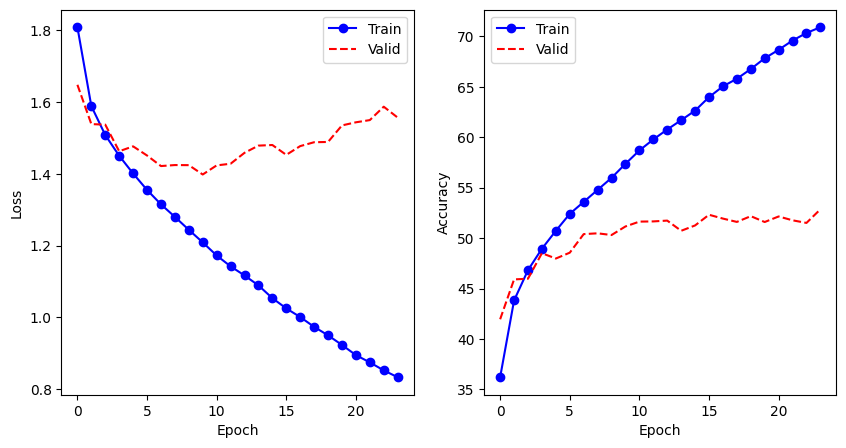

In [8]:
fig=plt.figure(1,figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(historySynScaL['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaL['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [9]:
def update_param(parameter_data, activation, gamma=0.1,mean = 0.1):
    activation = activation.data.numpy().mean(axis=(0)).squeeze()[:,None]
    param = parameter_data.numpy()
    new_param = param+gamma*np.clip((param*param)*(mean - activation).mean(),-1,1)
    return torch.from_numpy(new_param)
def perform_update(m):
    if type(m) == nn.Linear:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.in_features))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()

In [10]:

modelSynScaW = mlp().cuda()
test_loss_min_SynScaW= np.Inf
test_acc_max_SynScaW = -100
LR=5e-4
optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)
historySynScaW = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)

    modelSynScaW.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    modelSynScaW.apply(perform_update)
    #validate
    modelSynScaW.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaW:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaW, test_loss))
        torch.save(modelSynScaW.state_dict(), 'CIFAR10_SynScaW_MLP_leastLoss.pt')
        test_loss_min_SynScaW = test_loss
    if test_acc >= test_acc_max_SynScaW:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaW, test_acc))
        torch.save(modelSynScaW.state_dict(), 'CIFAR10_SynScaW_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaW = test_acc
    historySynScaW['train_loss'].append(train_loss)
    historySynScaW['valid_loss'].append(test_loss)
    historySynScaW['train_acc'].append(train_acc)
    historySynScaW['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.806556 - Testing Loss: 1.607885 - Training Accuracy: 36.50% - Testing Accuracy: 43.10%
Testing loss decreased (inf --> 1.607885). The new model saved.
Testing Acc increased (-100.000000 --> 43.100000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.578656 - Testing Loss: 1.563956 - Training Accuracy: 44.29% - Testing Accuracy: 44.28%
Testing loss decreased (1.607885 --> 1.563956). The new model saved.
Testing Acc increased (43.100000 --> 44.280000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.498780 - Testing Loss: 1.498867 - Training Accuracy: 47.09% - Testing Accuracy: 47.07%
Testing loss decreased (1.563956 --> 1.498867). The new model saved.
Testing Acc increased (44.280000 --> 47.070000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.443059 - Testing Loss: 1.448259 - Training Accuracy: 48.82% - Testing Accuracy: 48.49%
Testing loss decreased (1.498867 --> 1.448259). The new model saved.
Testing Acc increased (47.070000 --> 48.490000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.398619 - Testing Loss: 1.466629 - Training Accuracy: 50.63% - Testing Accuracy: 48.56%
Testing Acc increased (48.490000 --> 48.560000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.343619 - Testing Loss: 1.432985 - Training Accuracy: 52.70% - Testing Accuracy: 49.36%
Testing loss decreased (1.448259 --> 1.432985). The new model saved.
Testing Acc increased (48.560000 --> 49.360000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.311398 - Testing Loss: 1.444515 - Training Accuracy: 53.74% - Testing Accuracy: 49.26%
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.273796 - Testing Loss: 1.415802 - Training Accuracy: 55.13% - Testing Accuracy: 50.81%
Testing loss decreased (1.432985 --> 1.415802). The new model saved.
Testing Acc increased (49.360000 --> 50.810000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.238543 - Testing Loss: 1.450637 - Training Accuracy: 56.32% - Testing Accuracy: 50.26%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.203100 - Testing Loss: 1.410957 - Training Accuracy: 57.66% - Testing Accuracy: 51.79%
Testing loss decreased (1.415802 --> 1.410957). The new model saved.
Testing Acc increased (50.810000 --> 51.790000). The new model saved.
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.166929 - Testing Loss: 1.418998 - Training Accuracy: 59.11% - Testing Accuracy: 52.09%
Testing Acc increased (51.790000 --> 52.090000). The new model saved.
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 1.136742 - Testing Loss: 1.417058 - Training Accuracy: 60.38% - Testing Accuracy: 52.00%
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.112286 - Testing Loss: 1.435040 - Training Accuracy: 60.89% - Testing Accuracy: 51.59%
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.078953 - Testing Loss: 1.453644 - Training Accuracy: 62.17% - Testing Accuracy: 51.33%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.054581 - Testing Loss: 1.463323 - Training Accuracy: 63.30% - Testing Accuracy: 51.93%
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 1.012163 - Testing Loss: 1.459047 - Training Accuracy: 64.55% - Testing Accuracy: 52.74%
Testing Acc increased (52.090000 --> 52.740000). The new model saved.
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.991956 - Testing Loss: 1.479859 - Training Accuracy: 65.24% - Testing Accuracy: 52.64%
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.967961 - Testing Loss: 1.504944 - Training Accuracy: 66.19% - Testing Accuracy: 52.35%
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.948115 - Testing Loss: 1.504013 - Training Accuracy: 66.87% - Testing Accuracy: 52.35%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.917872 - Testing Loss: 1.513817 - Training Accuracy: 67.64% - Testing Accuracy: 52.62%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.886580 - Testing Loss: 1.536805 - Training Accuracy: 69.01% - Testing Accuracy: 52.36%
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.871963 - Testing Loss: 1.580034 - Training Accuracy: 69.54% - Testing Accuracy: 51.58%
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.849909 - Testing Loss: 1.602190 - Training Accuracy: 70.47% - Testing Accuracy: 52.44%
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.832211 - Testing Loss: 1.629282 - Training Accuracy: 70.89% - Testing Accuracy: 52.03%


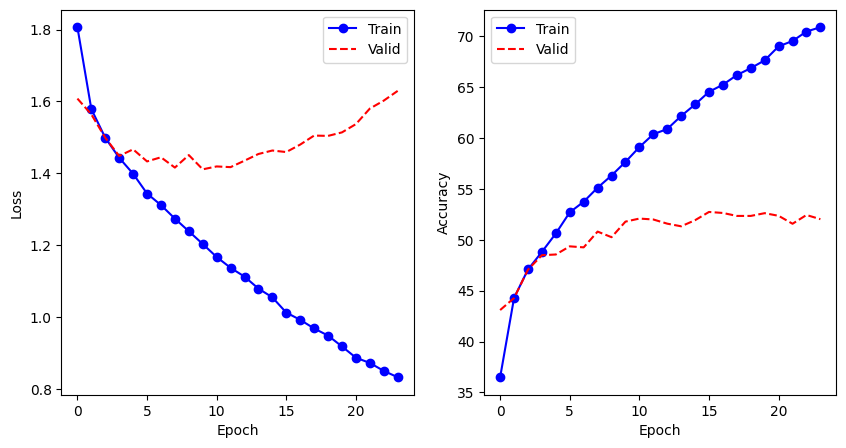

In [11]:

import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(historySynScaW['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaW['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
from tabulate import tabulate
data = [['Loss', test_loss_min, test_loss_min_SynScaL, test_loss_min_SynScaW],
['Accuracy', test_acc_max, test_acc_max_SynScaL, test_acc_max_SynScaW],
]
print (tabulate(data, headers=["Type", "Normal", "SynScaL", "SynScaW"]))

Type        Normal    SynScaL    SynScaW
--------  --------  ---------  ---------
Loss       1.39736    1.39835    1.41096
Accuracy  52.51      52.86      52.74
